# Explore and Pre-process data

In [ ]:
df = pd.read_csv('/kaggle/input/5g-nidd-dataset/Combined.csv')
df.info()

# 1: Mapping attack type & label to numeric

In [ ]:
df["Attack Type"].value_counts()

| Label | Attack Type       | Description                                  |
|:-----:|-------------------|--------------------------------------------------|
| 0     | **Benign**        | Legitimate network traffic                       | 
| 1     | **UDPFlood**      | Flood UDP packets to exhaust resources           | 
| 2     | **HTTPFlood**     | Send massive HTTP requests to web server         | 
| 3     | **SlowrateDoS**   | Slow requests to hold connections                | 
| 4     | **TCPConnectScan**| Full TCP handshake scan for open ports           | 
| 5     | **SYNScan**       | SYN packets only scan for ports                  | 
| 6     | **UDPScan**       | UDP packets scan for available services          | 
| 7     | **SYNFlood**      | SYN handshake flood to exhaust connection queue  | 
| 8     | **ICMPFlood**     | Flood ICMP echo requests (ping)                  | 


In [ ]:
attack_mapping = {
    'Benign': 0,
    'UDPFlood': 1,
    'HTTPFlood': 2,
    'SlowrateDoS': 3,
    'TCPConnectScan': 4,
    'SYNScan': 5,
    'UDPScan': 6,
    'SYNFlood': 7,
    'ICMPFlood': 8
}

# run once
df['Attack Type'] = df['Attack Type'].map(attack_mapping)
df['Attack Type'] = df['Attack Type'].astype('int64')

print(df['Attack Type'].value_counts())

In [ ]:
df["Label"].value_counts()

In [52]:
label_mapping = {
    'Benign': 0,
    'Malicious' : 1
}

df['Label'] = df['Label'].map(label_mapping)
df['Label'] = df['Label'].astype('int64')

print(df['Label'].value_counts())

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

# 2: State refactor

In [ ]:
print(df['State'].value_counts())

In [ ]:
#https://arxiv.org/pdf/2212.01298 s.10 - Features based on ANOVA F-scores
multiclass_top_features = [
    'tcp',
    'AckDat',
    'sHops',
    'Seq',
    'RST',
    'TcpRtt',
    'REQ',
    'dMeanPktSz',
    'Offset',
    'CON',
    'FIN',
    'sTtl',
    'e',
    'INT',
    'Mean',
    'Status',
    'icmp',
    'SrcTCPBase',
    'ed',
    'sMeanPktSz',
    'DstLoss',
    'Loss',
    'dTtl',
    'SrcBytes',
    'TotBytes'
]

In [ ]:
# One-hot encode State, keep original names, 0/1 values
state_dummies = pd.get_dummies(df['State']).astype('float64')

# Merge back into original dataframe
df = pd.concat([df.drop(columns=['State']), state_dummies], axis=1)


df.info()

# 3: Proto Refactor

In [ ]:
# One-hot encode State, keep original names, 0/1 values
state_dummies = pd.get_dummies(df['Proto']).astype('float64')

# Merge back into original dataframe
df = pd.concat([df.drop(columns=['Proto']), state_dummies], axis=1)


df.info()

# 4: Cause Refactor

In [ ]:
print(df['Cause'].value_counts())

In [ ]:
# One-hot encode State, keep original names, 0/1 values
state_dummies = pd.get_dummies(df['Cause']).astype('float64')

# Merge back into original dataframe
df = pd.concat([df.drop(columns=['Cause']), state_dummies], axis=1)

In [ ]:
df.info()

# 4: Refactor sDSb, dDSb and others

In [ ]:
df = df.drop(columns=['Attack Tool'])

In [ ]:
print(df['sDSb'].value_counts())

In [ ]:
print(df['dDSb'].value_counts())

In [ ]:
# One-hot encode State, keep original names, 0/1 values
state_dummies = pd.get_dummies(df['sDSb']).astype('float64')

# Merge back into original dataframe
df = pd.concat([df.drop(columns=['sDSb']), state_dummies], axis=1)

# One-hot encode State, keep original names, 0/1 values
state_dummies = pd.get_dummies(df['dDSb']).astype('float64')

# Merge back into original dataframe
df = pd.concat([df.drop(columns=['dDSb']), state_dummies], axis=1)

df.info()

# Training Phase

In [ ]:
import pandas as pd

df = pd.read_csv('/kaggle/input/5g-nidd-processed/processed_5g_dataset.csv')

#https://arxiv.org/pdf/2212.01298 s.10 - Features based on ANOVA F-scores
binary_top_features = [
    'Seq',
    'Offset',
    'sTtl',
    'e',
    'tcp',
    'AckDat',
    'RST',
    'INT',
    'TcpRtt',
    'icmp',
    'sMeanPktSz',
    'FIN',
    'sHops',
    'Mean',
    'dTtl',
    'SrcBytes',
    'TotBytes',
    'dMeanPktSz',
    'Status',
    'cs0',
    'SrcWin',
    'sTos',
    'ed',
    'CON',
    'REQ'
]


multiclass_top_features = [
    'tcp',
    'AckDat',
    'sHops',
    'Seq',
    'RST',
    'TcpRtt',
    'REQ',
    'dMeanPktSz',
    'Offset',
    'CON',
    'FIN',
    'sTtl',
    'e',
    'INT',
    'Mean',
    'Status',
    'icmp',
    'SrcTCPBase',
    'ed',
    'sMeanPktSz',
    'DstLoss',
    'Loss',
    'dTtl',
    'SrcBytes',
    'TotBytes'
]

features_to_use = [f for f in multiclass_top_features if f in df.columns]

print("Features:", features_to_use)

In [4]:
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score, f1_score
import optuna
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
import numpy as np
import seaborn as sns

In [5]:
X = df[features_to_use]
y = df['Attack Type']  


X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Optuna hyperparam stage 1: All hyperparams

In [38]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 9,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "max_bin": trial.suggest_int("max_bin", 95, 255, step=10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, step=0.01),
        "num_iterations": trial.suggest_int("num_iterations", 100, 2000, step=100),
        "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=5),
        "max_depth": trial.suggest_int("max_depth", 5, 15),  
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 95, step=10),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0, step=0.1),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0, step=0.1),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-6, 1.0, step=0.1),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-6, 1.0, step=0.1),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-6, 1.0, step=0.1),
        "device": "gpu",
        "verbose": -100
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=5),
        ]
    )
    y_pred = gbm.predict(X_valid)
    y_pred_labels = y_pred.argmax(axis=1)
    return accuracy_score(y_valid, y_pred_labels)

In [43]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-12-12 11:36:32,320] A new study created in memory with name: no-name-d36aae8b-aa9e-451c-9835-16b41f76bd99


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[62]	valid_0's multi_logloss: 0.00148049
[I 2025-12-12 11:36:50,407] Trial 0 finished with value: 0.999490085451809 and parameters: {'max_bin': 125, 'learning_rate': 0.18000000000000002, 'num_iterations': 1200, 'num_leaves': 70, 'max_depth': 12, 'min_data_in_leaf': 25, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'feature_fraction': 0.9, 'lambda_l1': 0.7000010000000001, 'lambda_l2': 0.7000010000000001, 'min_gain_to_split': 0.8000010000000001}. Best is trial 0 with value: 0.999490085451809.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 0.101107
[I 2025-12-12 11:36:58,196] Trial 1 finished with value: 0.9970309814210166 and parameters: {'max_bin': 215, 'learning_rate': 0.18000000000000002, 'num_iterations': 200, 'num_leaves': 175, 'max_depth': 11, 'min_data_in_leaf': 75, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.6, 'lambda_l1': 0.400001, 'lambda_l2': 1e-06, 'min_gain_to_split': 1e-06}. Best is trial 0 with value: 0.999490085451809.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[65]	valid_0's multi_logloss: 0.0015278
[I 2025-12-12 11:37:17,531] Trial 2 finished with value: 0.9993872800993511 and parameters: {'max_bin': 115, 'learning_rate': 0.16, 'num_iterations': 1100, 'num_leaves': 290, 'max_depth': 11, 'min_data_in_leaf': 15, 'bagging_fraction': 1.0, 'bagging_freq': 8, 'feature_fraction': 0.5, 'lambda_l1': 0.300001, 'lambda_l2': 0.7000010000000001, 'min_gain_to_split': 0.900001}. Best is trial 0 with value: 0.999490085451809.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[100]	valid_0's multi_logloss: 0.00131811
[I 2025-12-12 11:37:55,062] Trial 3 finished with value: 0.9995764419478735 and parameters: {'max_bin': 185, 'learning_rate': 0.060000000000000005, 'num_iterations': 1300, 'num_leaves': 250, 'max_depth': 11, 'min_data_in_leaf': 85, 'bagging_fraction': 0.7, 'bagging_freq': 10, 'feature_fraction': 1.0, 'lambda_l1': 0.500001, 'lambda_l2': 1e-06, 'min_gain_to_split': 0.100001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[120]	valid_0's multi_logloss: 0.00135798
[I 2025-12-12 11:38:29,126] Trial 4 finished with value: 0.9995229831645955 and parameters: {'max_bin': 135, 'learning_rate': 0.08, 'num_iterations': 1600, 'num_leaves': 230, 'max_depth': 12, 'min_data_in_leaf': 45, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'feature_fraction': 0.8, 'lambda_l1': 0.7000010000000001, 'lambda_l2': 0.400001, 'min_gain_to_split': 0.200001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's multi_logloss: 0.00120957
[I 2025-12-12 11:39:07,565] Trial 5 finished with value: 0.9995641053055786 and parameters: {'max_bin': 145, 'learning_rate': 0.09, 'num_iterations': 100, 'num_leaves': 270, 'max_depth': 14, 'min_data_in_leaf': 45, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'feature_fraction': 0.5, 'lambda_l1': 0.500001, 'lambda_l2': 0.8000010000000001, 'min_gain_to_split': 0.200001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[83]	valid_0's multi_logloss: 0.00127558
[I 2025-12-12 11:39:37,197] Trial 6 finished with value: 0.9995641053055786 and parameters: {'max_bin': 225, 'learning_rate': 0.16, 'num_iterations': 1100, 'num_leaves': 195, 'max_depth': 6, 'min_data_in_leaf': 85, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.5, 'lambda_l1': 0.900001, 'lambda_l2': 0.7000010000000001, 'min_gain_to_split': 0.300001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[56]	valid_0's multi_logloss: 0.00142831
[I 2025-12-12 11:39:57,724] Trial 7 finished with value: 0.9995270953786938 and parameters: {'max_bin': 125, 'learning_rate': 0.17, 'num_iterations': 1000, 'num_leaves': 260, 'max_depth': 9, 'min_data_in_leaf': 75, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'feature_fraction': 0.8, 'lambda_l1': 0.7000010000000001, 'lambda_l2': 0.7000010000000001, 'min_gain_to_split': 0.400001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[293]	valid_0's multi_logloss: 0.00134318
[I 2025-12-12 11:41:40,880] Trial 8 finished with value: 0.9994859732377106 and parameters: {'max_bin': 105, 'learning_rate': 0.060000000000000005, 'num_iterations': 600, 'num_leaves': 155, 'max_depth': 6, 'min_data_in_leaf': 35, 'bagging_fraction': 0.6, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.200001, 'lambda_l2': 0.6000010000000001, 'min_gain_to_split': 0.200001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.00143802
[I 2025-12-12 11:42:01,822] Trial 9 finished with value: 0.9994983098800055 and parameters: {'max_bin': 185, 'learning_rate': 0.12, 'num_iterations': 300, 'num_leaves': 290, 'max_depth': 9, 'min_data_in_leaf': 45, 'bagging_fraction': 1.0, 'bagging_freq': 10, 'feature_fraction': 0.7, 'lambda_l1': 0.7000010000000001, 'lambda_l2': 0.7000010000000001, 'min_gain_to_split': 0.900001}. Best is trial 3 with value: 0.9995764419478735.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[590]	valid_0's multi_logloss: 0.00109462
[I 2025-12-12 11:46:37,657] Trial 10 finished with value: 0.9996134518747584 and parameters: {'max_bin': 255, 'learning_rate': 0.01, 'num_iterations': 1800, 'num_leaves': 105, 'max_depth': 15, 'min_data_in_leaf': 95, 'bagging_fraction': 0.5, 'bagging_freq': 10, 'feature_fraction': 1.0, 'lambda_l1': 1e-06, 'lambda_l2': 1e-06, 'min_gain_to_split': 1e-06}. Best is trial 10 with value: 0.9996134518747584.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[628]	valid_0's multi_logloss: 0.00106828
[I 2025-12-12 11:51:11,975] Trial 11 finished with value: 0.9996381251593482 and parameters: {'max_bin': 255, 'learning_rate': 0.01, 'num_iterations': 1700, 'num_leaves': 75, 'max_depth': 15, 'min_data_in_leaf': 95, 'bagging_fraction': 0.5, 'bagging_freq': 10, 'feature_fraction': 1.0, 'lambda_l1': 1e-06, 'lambda_l2': 1e-06, 'min_gain_to_split': 1e-06}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[423]	valid_0's multi_logloss: 0.00112051
[I 2025-12-12 11:53:13,813] Trial 12 finished with value: 0.9995928908042668 and parameters: {'max_bin': 255, 'learning_rate': 0.02, 'num_iterations': 2000, 'num_leaves': 65, 'max_depth': 15, 'min_data_in_leaf': 95, 'bagging_fraction': 0.5, 'bagging_freq': 9, 'feature_fraction': 1.0, 'lambda_l1': 1e-06, 'lambda_l2': 0.200001, 'min_gain_to_split': 0.6000010000000001}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[665]	valid_0's multi_logloss: 0.00106479
[I 2025-12-12 11:57:21,115] Trial 13 finished with value: 0.9996134518747584 and parameters: {'max_bin': 255, 'learning_rate': 0.01, 'num_iterations': 2000, 'num_leaves': 110, 'max_depth': 15, 'min_data_in_leaf': 65, 'bagging_fraction': 0.5, 'bagging_freq': 5, 'feature_fraction': 0.9, 'lambda_l1': 1e-06, 'lambda_l2': 0.200001, 'min_gain_to_split': 1e-06}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[210]	valid_0's multi_logloss: 0.00121098
[I 2025-12-12 11:58:24,831] Trial 14 finished with value: 0.9995641053055786 and parameters: {'max_bin': 225, 'learning_rate': 0.04, 'num_iterations': 1600, 'num_leaves': 20, 'max_depth': 13, 'min_data_in_leaf': 95, 'bagging_fraction': 0.5, 'bagging_freq': 6, 'feature_fraction': 1.0, 'lambda_l1': 0.100001, 'lambda_l2': 0.200001, 'min_gain_to_split': 0.6000010000000001}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[288]	valid_0's multi_logloss: 0.00107812
[I 2025-12-12 12:00:16,395] Trial 15 finished with value: 0.9995723297337753 and parameters: {'max_bin': 205, 'learning_rate': 0.03, 'num_iterations': 1700, 'num_leaves': 120, 'max_depth': 14, 'min_data_in_leaf': 65, 'bagging_fraction': 0.6, 'bagging_freq': 9, 'feature_fraction': 0.9, 'lambda_l1': 0.200001, 'lambda_l2': 0.400001, 'min_gain_to_split': 1e-06}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.00107831
[I 2025-12-12 12:00:40,304] Trial 16 finished with value: 0.9996381251593482 and parameters: {'max_bin': 245, 'learning_rate': 0.11, 'num_iterations': 1800, 'num_leaves': 85, 'max_depth': 15, 'min_data_in_leaf': 95, 'bagging_fraction': 0.6, 'bagging_freq': 10, 'feature_fraction': 0.9, 'lambda_l1': 0.100001, 'lambda_l2': 0.100001, 'min_gain_to_split': 0.500001}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.00126744
[I 2025-12-12 12:01:03,101] Trial 17 finished with value: 0.9995147587363988 and parameters: {'max_bin': 155, 'learning_rate': 0.11, 'num_iterations': 1400, 'num_leaves': 25, 'max_depth': 8, 'min_data_in_leaf': 5, 'bagging_fraction': 0.6, 'bagging_freq': 5, 'feature_fraction': 0.9, 'lambda_l1': 0.200001, 'lambda_l2': 0.100001, 'min_gain_to_split': 0.6000010000000001}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[57]	valid_0's multi_logloss: 0.00112148
[I 2025-12-12 12:01:23,005] Trial 18 finished with value: 0.9995928908042668 and parameters: {'max_bin': 235, 'learning_rate': 0.13, 'num_iterations': 1500, 'num_leaves': 70, 'max_depth': 13, 'min_data_in_leaf': 65, 'bagging_fraction': 0.6, 'bagging_freq': 8, 'feature_fraction': 0.8, 'lambda_l1': 0.100001, 'lambda_l2': 0.300001, 'min_gain_to_split': 0.500001}. Best is trial 11 with value: 0.9996381251593482.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[63]	valid_0's multi_logloss: 0.00130835
[I 2025-12-12 12:01:46,556] Trial 19 finished with value: 0.9995394320209887 and parameters: {'max_bin': 205, 'learning_rate': 0.14, 'num_iterations': 1800, 'num_leaves': 130, 'max_depth': 13, 'min_data_in_leaf': 85, 'bagging_fraction': 0.8, 'bagging_freq': 9, 'feature_fraction': 0.7, 'lambda_l1': 0.300001, 'lambda_l2': 0.100001, 'min_gain_to_split': 0.400001}. Best is trial 11 with value: 0.9996381251593482.


In [45]:
from optuna.importance import get_param_importances

best_params_phase_1 = study.best_trial.params

print("Best parameters:", best_params_phase_1)

importances = get_param_importances(study)
print(importances)

Best parameters: {'max_bin': 255, 'learning_rate': 0.01, 'num_iterations': 1700, 'num_leaves': 75, 'max_depth': 15, 'min_data_in_leaf': 95, 'bagging_fraction': 0.5, 'bagging_freq': 10, 'feature_fraction': 1.0, 'lambda_l1': 1e-06, 'lambda_l2': 1e-06, 'min_gain_to_split': 1e-06}
{'learning_rate': 0.3274734452936079, 'num_iterations': 0.29566060647983794, 'max_bin': 0.13372304763681991, 'lambda_l2': 0.09936807465547672, 'min_data_in_leaf': 0.07557998149570157, 'min_gain_to_split': 0.016311152095721062, 'lambda_l1': 0.013734028408646293, 'max_depth': 0.011561998899290278, 'bagging_fraction': 0.009009839068127409, 'feature_fraction': 0.007527767909446063, 'bagging_freq': 0.005030335867130045, 'num_leaves': 0.005019722190194961}


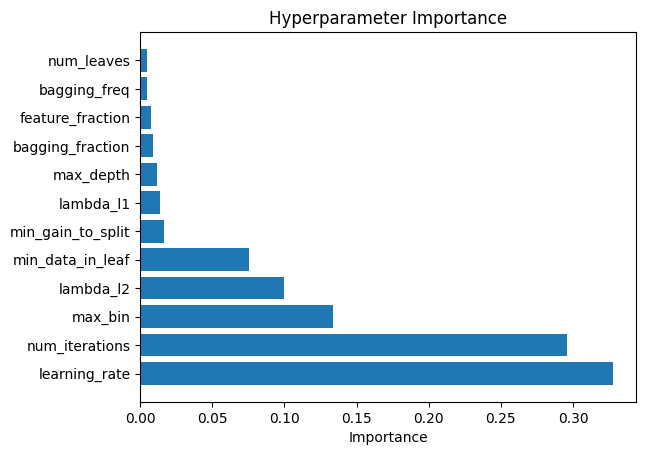

In [55]:
names = list(importances.keys())
scores = list(importances.values())

plt.barh(names, scores)
plt.xlabel("Importance")
plt.title("Hyperparameter Importance")

plt.savefig("hyperparam_importance.png", dpi=300, bbox_inches='tight') 

plt.show()

# Optuna hyperparam stage 2: learning rate & num of trees

In [42]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 9,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "max_bin": 255,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05, step=0.005),
        "num_iterations": trial.suggest_int("num_iterations", 1000, 3000, step=100),
        "num_leaves": 75,
        "max_depth": 15,  
        "min_data_in_leaf": 95,
        "bagging_fraction": 0.5,
        "bagging_freq": 10,
        "feature_fraction": 1.0,
        "lambda_l1": 1e-06,
        "lambda_l2": 1e-06,
        "min_gain_to_split": 1e-06,
        "device": "gpu",
        "verbose": -100
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=5),
        ]
    )

    y_train_pred_proba = gbm.predict(X_train)
    y_valid_pred_proba = gbm.predict(X_valid)

    y_train_pred = y_train_pred_proba.argmax(axis=1)
    y_valid_pred = y_valid_pred_proba.argmax(axis=1)

    #Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    valid_f1 = f1_score(y_valid, y_valid_pred, average="weighted")
    train_logloss = log_loss(y_train, y_train_pred_proba)
    valid_logloss = log_loss(y_valid, y_valid_pred_proba)


    trial.set_user_attr("train_acc", train_acc)
    trial.set_user_attr("valid_acc", valid_acc)
    trial.set_user_attr("train_f1", train_f1)
    trial.set_user_attr("valid_f1", valid_f1)
    trial.set_user_attr("train_log_loss", train_logloss)
    trial.set_user_attr("valid_log_loss", valid_logloss)
    
    return valid_acc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2025-12-12 18:41:08,967] A new study created in memory with name: no-name-2b50c521-90ef-4aeb-9b33-4ba942f14f64


  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[104]	valid_0's multi_logloss: 0.00282248
[I 2025-12-12 18:42:25,798] Trial 0 finished with value: 0.999555880877382 and parameters: {'learning_rate': 0.035, 'num_iterations': 1500}. Best is trial 0 with value: 0.999555880877382.
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[141]	valid_0's multi_logloss: 0.00134897
[I 2025-12-12 18:44:10,169] Trial 1 finished with value: 0.9995928908042668 and parameters: {'learning_rate': 0.035, 'num_iterations': 2700}. Best is trial 1 with value: 0.9995928908042668.
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[630]	valid_0's multi_logloss: 0.00105725
[I 2025-12-12 18:51:20,367] Trial 2 finished with value: 0.9996422373734466 and parameters: {'learning_rate': 0.01, 'num_iterations': 2100}. Best is trial 2 with value: 0.9996422373734466.
Training until validat

In [43]:
data = []
for t in study.trials:
    data.append({
        "learning_rate": t.params["learning_rate"],
        "num_iterations": t.params["num_iterations"],
        "valid_acc": t.value,
        "train_acc": t.user_attrs["train_acc"],
        "valid_f1": t.user_attrs["valid_f1"],
        "train_f1": t.user_attrs["train_f1"],
        "train_log_loss": t.user_attrs["train_log_loss"],
        "valid_log_loss": t.user_attrs["valid_log_loss"],
    })

df_trials_1 = pd.DataFrame(data)
# df_trials_1.to_csv("lr_num_tree_optuna_log.csv", index=False, encoding="utf-8")
print(df_trials_1)

   learning_rate  num_iterations  valid_acc  train_acc  valid_f1  train_f1  \
0          0.035            1500   0.999556   0.999627  0.999556  0.999627   
1          0.035            2700   0.999593   0.999716  0.999593  0.999716   
2          0.010            2100   0.999642   0.999757  0.999642  0.999757   
3          0.020            2400   0.999601   0.999759  0.999601  0.999759   
4          0.020            1800   0.999605   0.999760  0.999605  0.999760   
5          0.025            1700   0.999613   0.999755  0.999613  0.999755   
6          0.040            1600   0.999605   0.999756  0.999605  0.999756   
7          0.035            1700   0.999597   0.999713  0.999597  0.999713   
8          0.050            2200   0.999585   0.999717  0.999585  0.999717   
9          0.010            2200   0.999622   0.999756  0.999622  0.999756   

   train_log_loss  valid_log_loss  
0        0.002522        0.002829  
1        0.000971        0.001355  
2        0.000630        0.001057

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


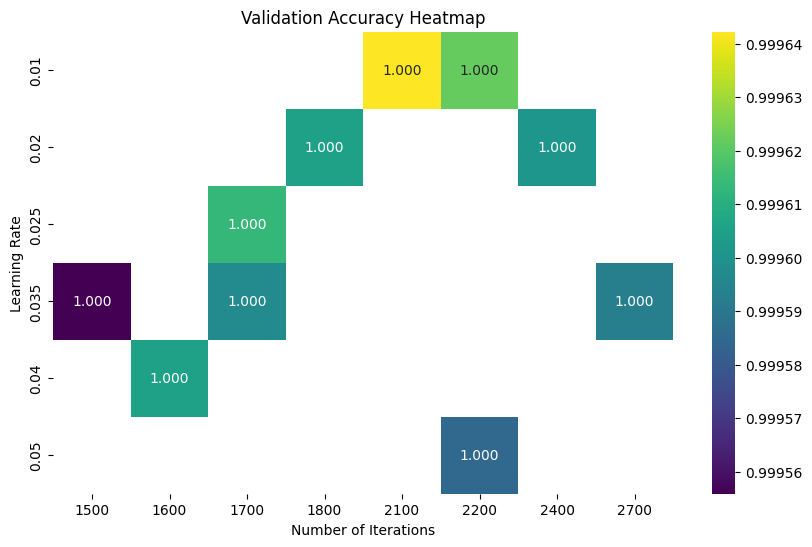

In [45]:
# Aggregate duplicates by mean
df_agg = df_trials_1.groupby(['learning_rate', 'num_iterations'], as_index=False)['valid_acc'].mean()

# Pivot
heatmap_data = df_agg.pivot(index='learning_rate', columns='num_iterations', values='valid_acc')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
plt.title("Validation Accuracy Heatmap")
plt.ylabel("Learning Rate")
plt.xlabel("Number of Iterations")

plt.savefig("heatmap_lr_num_tree_freeze.png", dpi=300, bbox_inches='tight')

plt.show()

In [47]:
#phase 1: freeze point
# lr = 0.01
# n_iter = 2100
#Other explore
df_lr_ni = pd.read_csv("/kaggle/input/5g-nidd-log/lr_num_tree_optuna_log.csv")
# print (df_lr_ni)
df_lr_ni.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   learning_rate   25 non-null     float64
 1   num_iterations  25 non-null     int64  
 2   valid_acc       25 non-null     float64
 3   train_acc       25 non-null     float64
 4   valid_f1        25 non-null     float64
 5   train_f1        25 non-null     float64
 6   train_log_loss  25 non-null     float64
 7   valid_log_loss  25 non-null     float64
dtypes: float64(7), int64(1)
memory usage: 1.7 KB


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Saved: heatmap_lr_ni_validation_accuracy.png


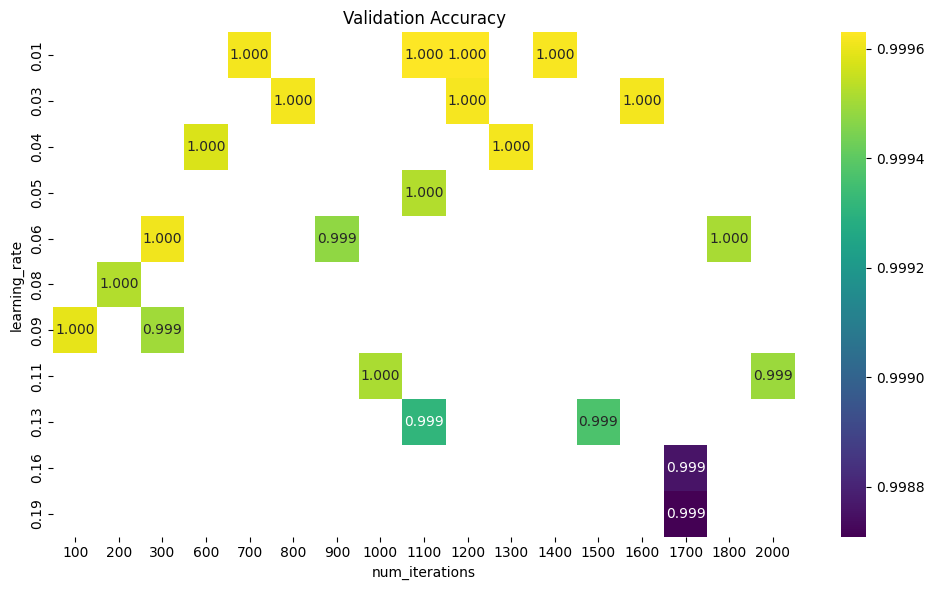

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Saved: heatmap_lr_ni_validation_f1_score.png


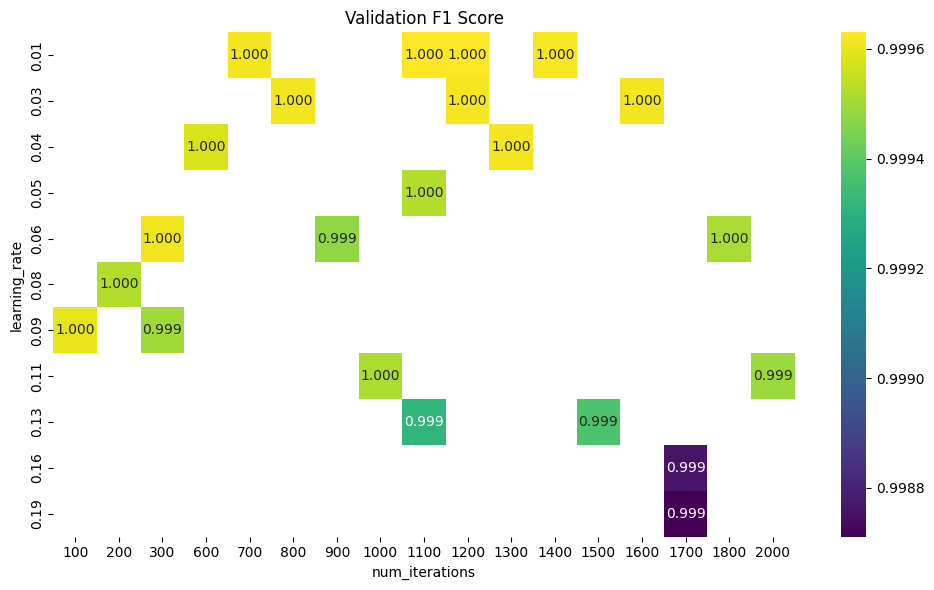

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Saved: heatmap_lr_ni_validation_log_loss.png


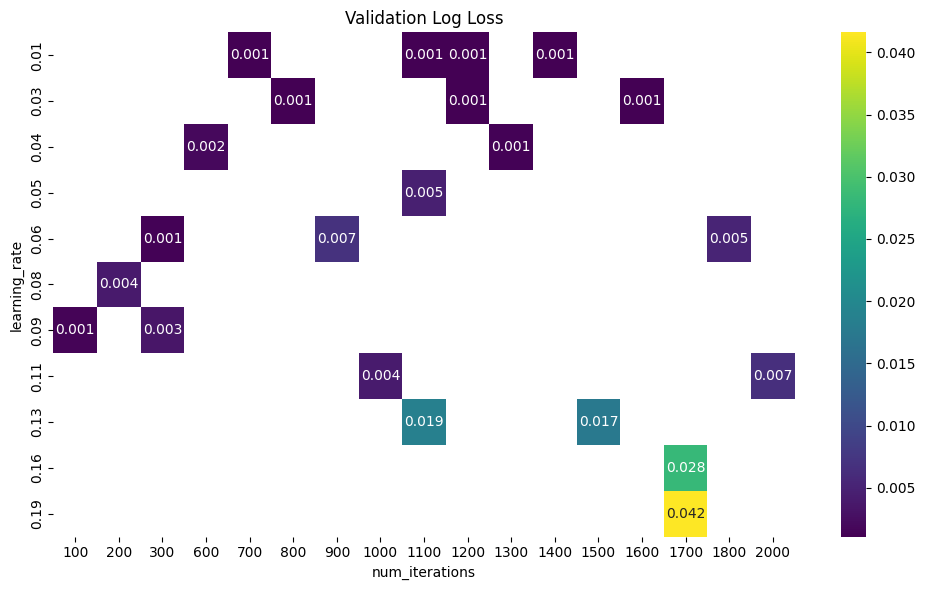

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Saved: heatmap_lr_ni_overfit_gap_train_acc_valid_acc.png


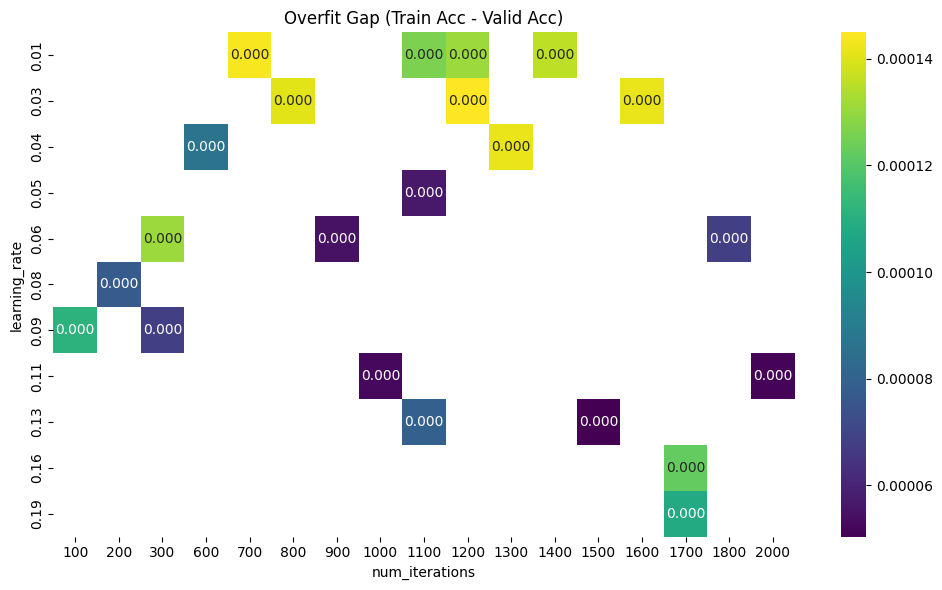

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Saved: heatmap_lr_ni_overfit_gap_valid_ll_train_ll.png


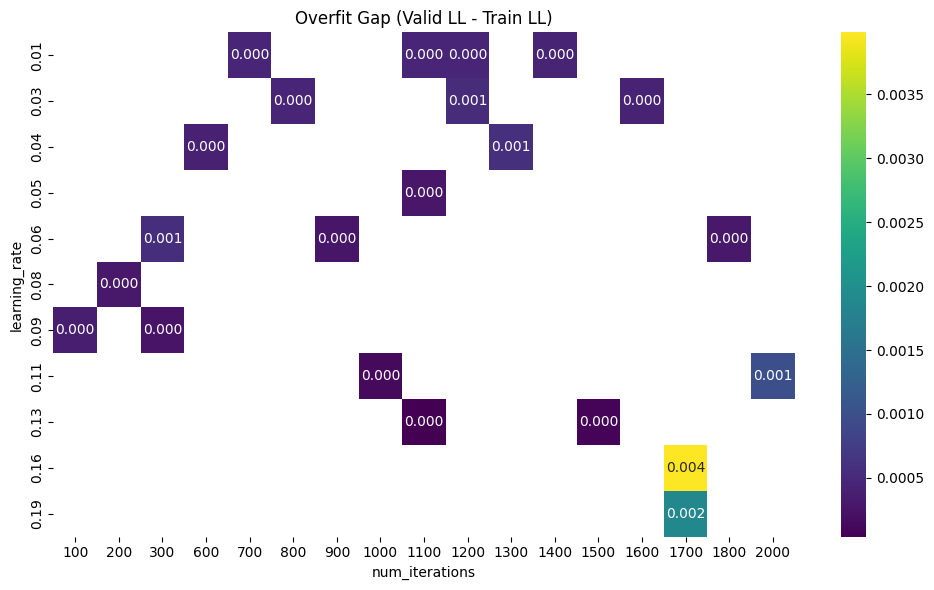

In [50]:
import re
def slugify(text):
    # convert title → file-friendly name
    text = text.lower()
    text = re.sub(r'[^a-z0-9]+', '_', text)
    text = re.sub(r'_+', '_', text).strip('_')
    return text

def plot_heatmap(df, value_col, title):
    df_agg = df.groupby(['learning_rate', 'num_iterations'], as_index=False)[value_col].mean()
    heatmap_data = df_agg.pivot(index='learning_rate', columns='num_iterations', values=value_col)
    heatmap_data = heatmap_data.replace([np.inf, -np.inf], np.nan)

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", mask=heatmap_data.isna())
    plt.title(title)
    plt.ylabel("learning_rate")
    plt.xlabel("num_iterations")
    plt.tight_layout()

    fname = f"heatmap_lr_ni_{slugify(title)}.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    print(f"Saved: {fname}")
    
    plt.show()


# 1. Heatmap valid_acc
plot_heatmap(df_lr_ni, "valid_acc", "Validation Accuracy")

# 2. Heatmap valid_f1
plot_heatmap(df_lr_ni, "valid_f1", "Validation F1 Score")

# 3. Heatmap valid_log_loss
plot_heatmap(df_lr_ni, "valid_log_loss", "Validation Log Loss")

# 4. Heatmap overfit gap (ACC)
df_lr_ni["acc_gap"] = df_lr_ni["train_acc"] - df_lr_ni["valid_acc"]
plot_heatmap(df_lr_ni, "acc_gap", "Overfit Gap (Train Acc - Valid Acc)")

# 5. Heatmap overfit gap (LOG LOSS)
df_lr_ni["logloss_gap"] = df_lr_ni["valid_log_loss"] - df_lr_ni["train_log_loss"]
plot_heatmap(df_lr_ni, "logloss_gap", "Overfit Gap (Valid LL - Train LL)")

# OPtuna hyperparam stage 3: max_bin, min_data_in_leaf, lamda_l2

In [33]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 9,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "max_bin": trial.suggest_int("max_bin", 600, 1500, step=50),
        "learning_rate": 0.01,
        "num_iterations": 2100,
        "num_leaves": 75,
        "max_depth": 15,  
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 60, 150, step=10),
        "bagging_fraction": 0.5,
        "bagging_freq": 10,
        "feature_fraction": 1.0,
        "lambda_l1": 1e-06,
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-6, 1.501, step=0.1),
        "min_gain_to_split": 1e-06,
        # "device": "gpu",
        "verbose": -100
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=5),
        ]
    )

    y_train_pred_proba = gbm.predict(X_train)
    y_valid_pred_proba = gbm.predict(X_valid)

    y_train_pred = y_train_pred_proba.argmax(axis=1)
    y_valid_pred = y_valid_pred_proba.argmax(axis=1)

    #Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    valid_f1 = f1_score(y_valid, y_valid_pred, average="weighted")
    train_logloss = log_loss(y_train, y_train_pred_proba)
    valid_logloss = log_loss(y_valid, y_valid_pred_proba)


    trial.set_user_attr("train_acc", train_acc)
    trial.set_user_attr("valid_acc", valid_acc)
    trial.set_user_attr("train_f1", train_f1)
    trial.set_user_attr("valid_f1", valid_f1)
    trial.set_user_attr("train_log_loss", train_logloss)
    trial.set_user_attr("valid_log_loss", valid_logloss)
    
    return valid_acc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20, show_progress_bar=True)

[I 2025-12-13 08:25:41,856] A new study created in memory with name: no-name-aa8e9c14-e322-4831-a012-dbe780bd3d03


  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[680]	valid_0's multi_logloss: 0.000872523
[I 2025-12-13 08:29:45,913] Trial 0 finished with value: 0.9996422373734466 and parameters: {'max_bin': 650, 'min_data_in_leaf': 120, 'lambda_l2': 1.100001}. Best is trial 0 with value: 0.9996422373734466.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[747]	valid_0's multi_logloss: 0.000879444
[I 2025-12-13 08:34:27,908] Trial 1 finished with value: 0.9996175640888567 and parameters: {'max_bin': 950, 'min_data_in_leaf': 130, 'lambda_l2': 1.400001}. Best is trial 0 with value: 0.9996422373734466.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[630]	valid_0's multi_logloss: 0.000885674
[I 2025-12-13 08:38:21,973] Trial 2 finished with value: 0.9996545740157415 and parameters: {'max_bin': 850, 'min_data_in_leaf': 140, 'lambda_l2': 0.200001}. Best is trial 2 with value: 0.9996545740157415.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[745]	valid_0's multi_logloss: 0.000833751
[I 2025-12-13 08:43:15,657] Trial 3 finished with value: 0.9996504618016432 and parameters: {'max_bin': 1400, 'min_data_in_leaf': 140, 'lambda_l2': 0.900001}. Best is trial 2 with value: 0.9996545740157415.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[680]	valid_0's multi_logloss: 0.000866334
[I 2025-12-13 08:47:40,541] Trial 4 finished with value: 0.9996545740157415 and parameters: {'max_bin': 1150, 'min_data_in_leaf': 130, 'lambda_l2': 0.200001}. Best is trial 2 with value: 0.9996545740157415.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[755]	valid_0's multi_logloss: 0.000809591
[I 2025-12-13 08:52:45,134] Trial 5 finished with value: 0.9996586862298399 and parameters: {'max_bin': 1300, 'min_data_in_leaf': 140, 'lambda_l2': 0.6000010000000001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[800]	valid_0's multi_logloss: 0.000844731
[I 2025-12-13 08:58:05,897] Trial 6 finished with value: 0.9996545740157415 and parameters: {'max_bin': 600, 'min_data_in_leaf': 150, 'lambda_l2': 0.7000010000000001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[800]	valid_0's multi_logloss: 0.000787397
[I 2025-12-13 09:03:34,122] Trial 7 finished with value: 0.9996586862298399 and parameters: {'max_bin': 1300, 'min_data_in_leaf': 150, 'lambda_l2': 0.8000010000000001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[800]	valid_0's multi_logloss: 0.000829584
[I 2025-12-13 09:09:01,457] Trial 8 finished with value: 0.9996586862298399 and parameters: {'max_bin': 1300, 'min_data_in_leaf': 90, 'lambda_l2': 1.400001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[684]	valid_0's multi_logloss: 0.000864524
[I 2025-12-13 09:13:27,541] Trial 9 finished with value: 0.9996545740157415 and parameters: {'max_bin': 1050, 'min_data_in_leaf': 120, 'lambda_l2': 0.200001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[742]	valid_0's multi_logloss: 0.000839754
[I 2025-12-13 09:18:37,421] Trial 10 finished with value: 0.9996504618016432 and parameters: {'max_bin': 1500, 'min_data_in_leaf': 60, 'lambda_l2': 0.500001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[750]	valid_0's multi_logloss: 0.000821028
[I 2025-12-13 09:23:44,286] Trial 11 finished with value: 0.9996669106580365 and parameters: {'max_bin': 1250, 'min_data_in_leaf': 100, 'lambda_l2': 0.6000010000000001}. Best is trial 11 with value: 0.9996669106580365.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[685]	valid_0's multi_logloss: 0.000865985
[I 2025-12-13 09:28:10,945] Trial 12 finished with value: 0.9996710228721348 and parameters: {'max_bin': 1200, 'min_data_in_leaf': 90, 'lambda_l2': 0.500001}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[704]	valid_0's multi_logloss: 0.000872028
[I 2025-12-13 09:32:45,110] Trial 13 finished with value: 0.999646349587545 and parameters: {'max_bin': 1150, 'min_data_in_leaf': 90, 'lambda_l2': 0.400001}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[752]	valid_0's multi_logloss: 0.000852171
[I 2025-12-13 09:37:45,157] Trial 14 finished with value: 0.9996545740157415 and parameters: {'max_bin': 1150, 'min_data_in_leaf': 90, 'lambda_l2': 1.100001}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[600]	valid_0's multi_logloss: 0.000912204
[I 2025-12-13 09:42:39,890] Trial 15 finished with value: 0.9996422373734466 and parameters: {'max_bin': 800, 'min_data_in_leaf': 70, 'lambda_l2': 1e-06}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[800]	valid_0's multi_logloss: 0.000842195
[I 2025-12-13 09:48:04,591] Trial 16 finished with value: 0.9996545740157415 and parameters: {'max_bin': 1050, 'min_data_in_leaf': 100, 'lambda_l2': 0.400001}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[700]	valid_0's multi_logloss: 0.000841674
[I 2025-12-13 09:52:37,254] Trial 17 finished with value: 0.9996504618016432 and parameters: {'max_bin': 1450, 'min_data_in_leaf': 80, 'lambda_l2': 1.000001}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[794]	valid_0's multi_logloss: 0.000809776
[I 2025-12-13 09:58:06,596] Trial 18 finished with value: 0.9996545740157415 and parameters: {'max_bin': 1250, 'min_data_in_leaf': 110, 'lambda_l2': 0.7000010000000001}. Best is trial 12 with value: 0.9996710228721348.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.501] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 1.500001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[725]	valid_0's multi_logloss: 0.000857496
[I 2025-12-13 10:02:58,511] Trial 19 finished with value: 0.9996257885170533 and parameters: {'max_bin': 1400, 'min_data_in_leaf': 100, 'lambda_l2': 0.400001}. Best is trial 12 with value: 0.9996710228721348.


In [37]:
data = []
for t in study.trials:
    data.append({
        "max_bin": t.params["max_bin"],
        "min_data_in_leaf": t.params["min_data_in_leaf"],
        "lambda_l2": t.params["lambda_l2"],
        "valid_acc": t.value,
        "train_acc": t.user_attrs["train_acc"],
        "valid_f1": t.user_attrs["valid_f1"],
        "train_f1": t.user_attrs["train_f1"],
        "train_log_loss": t.user_attrs["train_log_loss"],
        "valid_log_loss": t.user_attrs["valid_log_loss"],
    })

df_trials_2 = pd.DataFrame(data)
df_trials_2.to_csv("v2_optuna_ph2_log.csv", index=False, encoding="utf-8")
print(df_trials_2)

    max_bin  min_data_in_leaf  lambda_l2  valid_acc  train_acc  valid_f1  \
0       650               120   1.100001   0.999642   0.999752  0.999642   
1       950               130   1.400001   0.999618   0.999759  0.999618   
2       850               140   0.200001   0.999655   0.999768  0.999655   
3      1400               140   0.900001   0.999650   0.999772  0.999650   
4      1150               130   0.200001   0.999655   0.999763  0.999655   
5      1300               140   0.600001   0.999659   0.999769  0.999659   
6       600               150   0.700001   0.999655   0.999770  0.999655   
7      1300               150   0.800001   0.999659   0.999770  0.999659   
8      1300                90   1.400001   0.999659   0.999759  0.999659   
9      1050               120   0.200001   0.999655   0.999776  0.999655   
10     1500                60   0.500001   0.999650   0.999776  0.999650   
11     1250               100   0.600001   0.999667   0.999765  0.999667   
12     1200 

Saved: bubble_v2_validation_accuracy.png


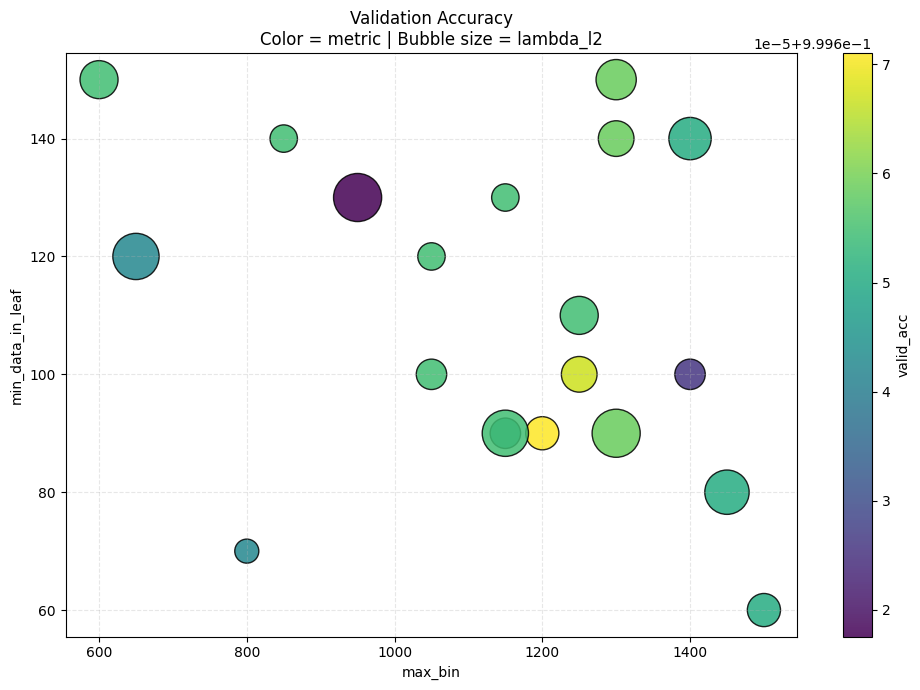

Saved: bubble_v2_validation_f1_score.png


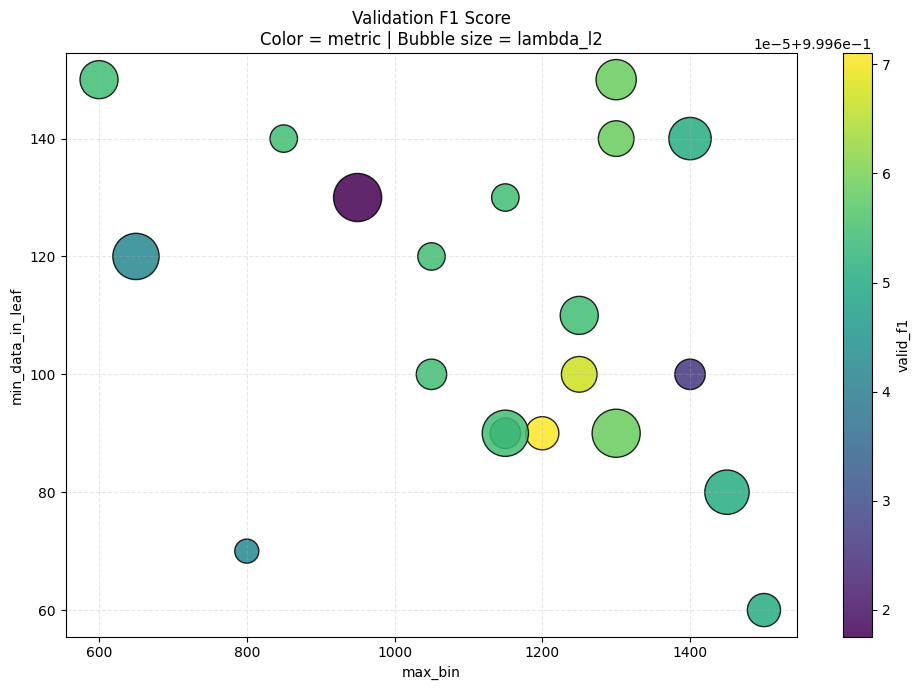

Saved: bubble_v2_validation_log_loss.png


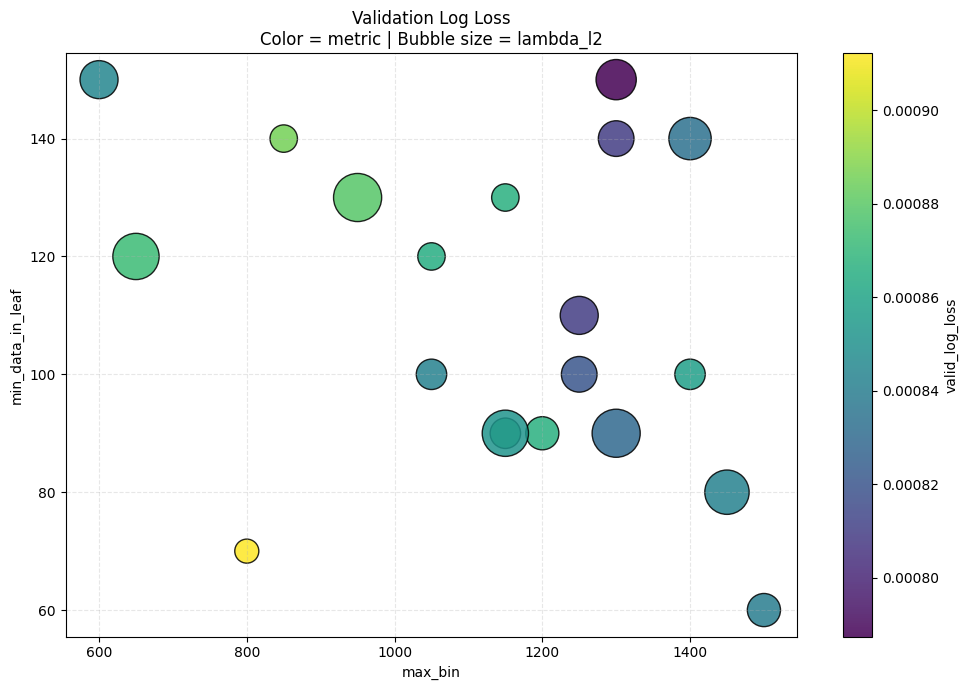

Saved: bubble_v2_overfit_gap_train_acc_valid_acc.png


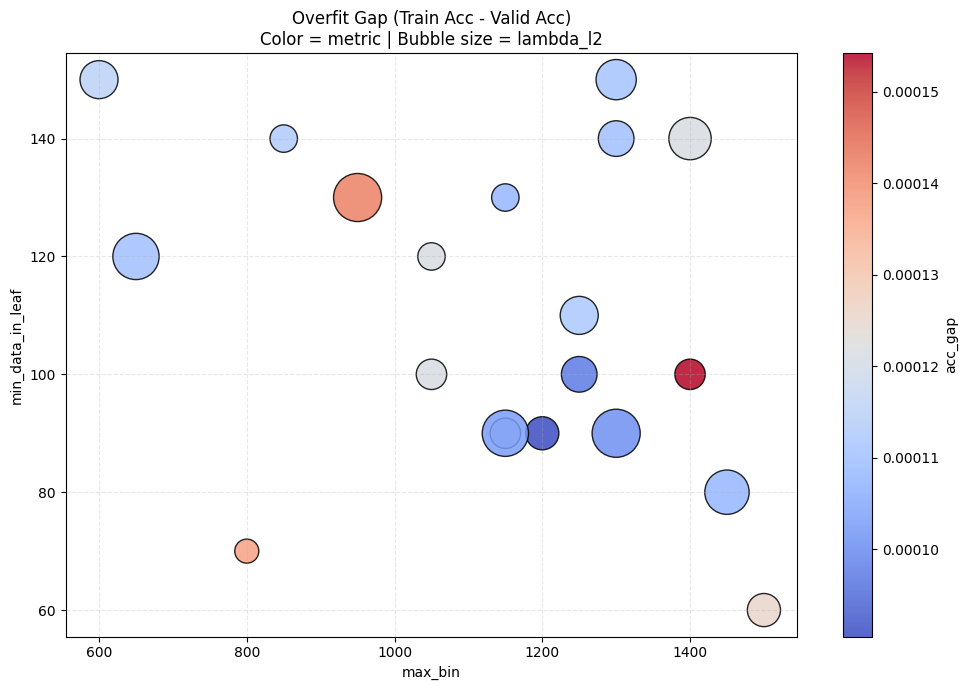

Saved: bubble_v2_overfit_gap_valid_ll_train_ll.png


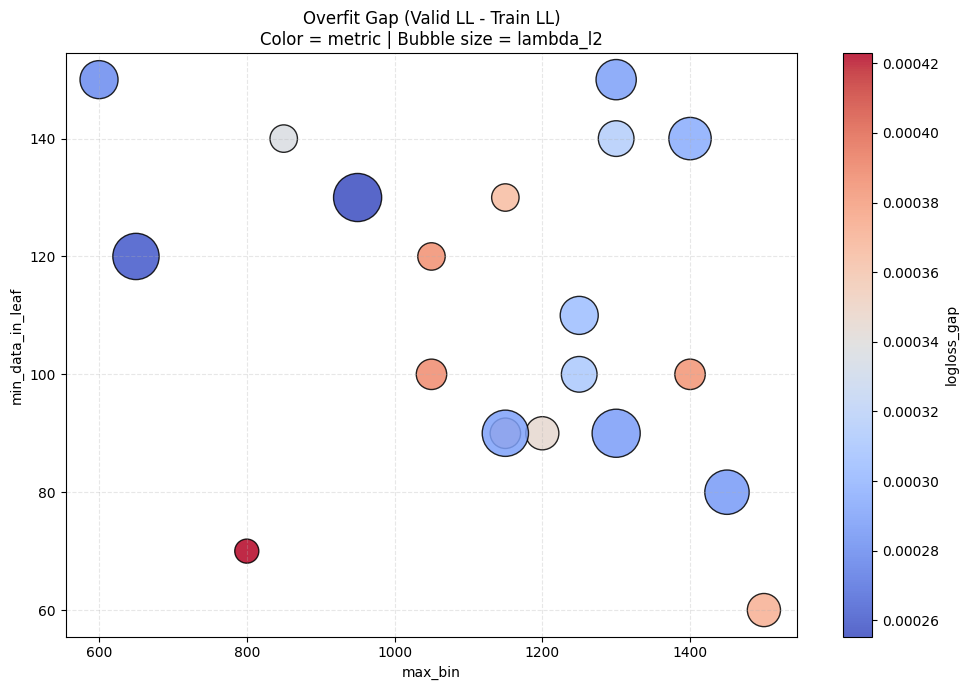

In [36]:
import re

def slugify(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9]+', '_', text)
    text = re.sub(r'_+', '_', text).strip('_')
    return text


def plot_bubble(
    df,
    value_col,
    title,
    cmap="viridis",
    size_col="lambda_l2",
):
    # ---- bubble size = rank(lambda_l2) ----
    rank = df[size_col].rank(method="dense")
    sizes = 300 + (rank - 1) / (rank.max() - 1) * 900

    fig, ax = plt.subplots(figsize=(10, 7))

    sc = ax.scatter(
        df["max_bin"],
        df["min_data_in_leaf"],
        c=df[value_col],
        s=sizes,
        cmap=cmap,
        alpha=0.85,
        edgecolors="black"
    )

    # colorbar
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label(value_col)

    ax.set_xlabel("max_bin")
    ax.set_ylabel("min_data_in_leaf")
    ax.set_title(
        f"{title}\n"
        "Color = metric | Bubble size = lambda_l2"
    )

    ax.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()

    fname = f"bubble_v2_{slugify(title)}.png"
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    print(f"Saved: {fname}")

    plt.show()


# Gap metrics
df_trials_2["acc_gap"] = (
    df_trials_2["train_acc"] - df_trials_2["valid_acc"]
)

df_trials_2["logloss_gap"] = (
    df_trials_2["valid_log_loss"] - df_trials_2["train_log_loss"]
)


# 1. Validation Accuracy
plot_bubble(
    df_trials_2,
    value_col="valid_acc",
    title="Validation Accuracy"
)

# 2. Validation F1
plot_bubble(
    df_trials_2,
    value_col="valid_f1",
    title="Validation F1 Score"
)

# 3. Validation Log Loss
plot_bubble(
    df_trials_2,
    value_col="valid_log_loss",
    title="Validation Log Loss"
)

# 4. Overfit gap (Accuracy)
plot_bubble(
    df_trials_2,
    value_col="acc_gap",
    title="Overfit Gap (Train Acc - Valid Acc)",
    cmap="coolwarm"
)

# 5. Overfit gap (Log loss)
plot_bubble(
    df_trials_2,
    value_col="logloss_gap",
    title="Overfit Gap (Valid LL - Train LL)",
    cmap="coolwarm"
)


Sweet spot:
- lr = 0.01
- n_iter = 2100
- max_bin = 1005 (>600)
- min_data_in_leaf = 85 (>60)
- l2 = 0.6 (no pattern yet)

# Optuna hyperparam stage 4: leave, depth, bagging, feat_frac, lambda_l1, min_gain

In [38]:
def objective(trial):
    params = {
        "objective": "multiclass",
        "num_class": 9,
        "metric": "multi_logloss",
        "boosting_type": "gbdt",
        "max_bin": 1005,
        "learning_rate": 0.01,
        "num_iterations": 2100,
        "num_leaves": trial.suggest_int("num_leaves", 20, 300, step=5),
        "max_depth": trial.suggest_int("max_depth", 5, 15),  
        "min_data_in_leaf": 85,
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0, step=0.1),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0, step=0.1),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-6, 1.0, step=0.1),
        "lambda_l2": 0.6,
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 1e-6, 1.0, step=0.1),
        # "device": "gpu",
        "verbose": -100
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    gbm = lgb.train(
        params,
        dtrain,
        valid_sets=[dvalid],
        num_boost_round=500,
        callbacks=[
            lgb.early_stopping(stopping_rounds=5),
        ]
    )

    y_train_pred_proba = gbm.predict(X_train)
    y_valid_pred_proba = gbm.predict(X_valid)

    y_train_pred = y_train_pred_proba.argmax(axis=1)
    y_valid_pred = y_valid_pred_proba.argmax(axis=1)

    #Metrics
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)
    train_f1 = f1_score(y_train, y_train_pred, average="weighted")
    valid_f1 = f1_score(y_valid, y_valid_pred, average="weighted")
    train_logloss = log_loss(y_train, y_train_pred_proba)
    valid_logloss = log_loss(y_valid, y_valid_pred_proba)


    trial.set_user_attr("train_acc", train_acc)
    trial.set_user_attr("valid_acc", valid_acc)
    trial.set_user_attr("train_f1", train_f1)
    trial.set_user_attr("valid_f1", valid_f1)
    trial.set_user_attr("train_log_loss", train_logloss)
    trial.set_user_attr("valid_log_loss", valid_logloss)
    
    return valid_acc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25, show_progress_bar=True)

[I 2025-12-13 10:26:47,792] A new study created in memory with name: no-name-a4c4adb0-3383-44e5-aaf2-e5186141aeb7


  0%|          | 0/25 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[967]	valid_0's multi_logloss: 0.00103045
[I 2025-12-13 10:32:32,471] Trial 0 finished with value: 0.9996175640888567 and parameters: {'num_leaves': 95, 'max_depth': 12, 'bagging_fraction': 0.6, 'bagging_freq': 4, 'feature_fraction': 0.5, 'lambda_l1': 0.300001, 'min_gain_to_split': 0.6000010000000001}. Best is trial 0 with value: 0.9996175640888567.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[774]	valid_0's multi_logloss: 0.00111264
[I 2025-12-13 10:36:41,623] Trial 1 finished with value: 0.9996052274465618 and parameters: {'num_leaves': 105, 'max_depth': 6, 'bagging_fraction': 0.7, 'bagging_freq': 6, 'feature_fraction': 0.9, 'lambda_l1': 0.7000010000000001, 'min_gain_to_split': 0.6000010000000001}. Best is trial 0 with value: 0.9996175640888567.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1086]	valid_0's multi_logloss: 0.00093901
[I 2025-12-13 10:42:44,569] Trial 2 finished with value: 0.9996545740157415 and parameters: {'num_leaves': 195, 'max_depth': 6, 'bagging_fraction': 0.9, 'bagging_freq': 6, 'feature_fraction': 0.8, 'lambda_l1': 0.300001, 'min_gain_to_split': 0.500001}. Best is trial 2 with value: 0.9996545740157415.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1043]	valid_0's multi_logloss: 0.00105488
[I 2025-12-13 10:48:48,920] Trial 3 finished with value: 0.9996134518747584 and parameters: {'num_leaves': 180, 'max_depth': 8, 'bagging_fraction': 0.8, 'bagging_freq': 8, 'feature_fraction': 0.6, 'lambda_l1': 0.300001, 'min_gain_to_split': 0.900001}. Best is trial 2 with value: 0.9996545740157415.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[930]	valid_0's multi_logloss: 0.00104119
[I 2025-12-13 10:54:01,550] Trial 4 finished with value: 0.9996052274465618 and parameters: {'num_leaves': 45, 'max_depth': 12, 'bagging_fraction': 0.5, 'bagging_freq': 2, 'feature_fraction': 0.6, 'lambda_l1': 0.300001, 'min_gain_to_split': 0.7000010000000001}. Best is trial 2 with value: 0.9996545740157415.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1050]	valid_0's multi_logloss: 0.000893464
[I 2025-12-13 10:59:54,978] Trial 5 finished with value: 0.9996586862298399 and parameters: {'num_leaves': 195, 'max_depth': 7, 'bagging_fraction': 0.6, 'bagging_freq': 1, 'feature_fraction': 0.8, 'lambda_l1': 0.300001, 'min_gain_to_split': 0.300001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[800]	valid_0's multi_logloss: 0.000948736
[I 2025-12-13 11:04:25,559] Trial 6 finished with value: 0.9996299007311517 and parameters: {'num_leaves': 220, 'max_depth': 13, 'bagging_fraction': 0.6, 'bagging_freq': 10, 'feature_fraction': 0.8, 'lambda_l1': 0.400001, 'min_gain_to_split': 0.400001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1114]	valid_0's multi_logloss: 0.00102676
[I 2025-12-13 11:10:17,933] Trial 7 finished with value: 0.999646349587545 and parameters: {'num_leaves': 60, 'max_depth': 5, 'bagging_fraction': 0.8, 'bagging_freq': 3, 'feature_fraction': 0.8, 'lambda_l1': 0.100001, 'min_gain_to_split': 0.8000010000000001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[907]	valid_0's multi_logloss: 0.00100751
[I 2025-12-13 11:14:33,974] Trial 8 finished with value: 0.999646349587545 and parameters: {'num_leaves': 45, 'max_depth': 6, 'bagging_fraction': 1.0, 'bagging_freq': 1, 'feature_fraction': 0.9, 'lambda_l1': 0.500001, 'min_gain_to_split': 0.6000010000000001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[972]	valid_0's multi_logloss: 0.000850581
[I 2025-12-13 11:20:13,152] Trial 9 finished with value: 0.9996586862298399 and parameters: {'num_leaves': 150, 'max_depth': 8, 'bagging_fraction': 0.9, 'bagging_freq': 9, 'feature_fraction': 0.9, 'lambda_l1': 0.300001, 'min_gain_to_split': 0.200001}. Best is trial 5 with value: 0.9996586862298399.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1153]	valid_0's multi_logloss: 0.000851735
[I 2025-12-13 11:28:31,725] Trial 10 finished with value: 0.9996627984439382 and parameters: {'num_leaves': 295, 'max_depth': 9, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 1.0, 'lambda_l1': 0.900001, 'min_gain_to_split': 1e-06}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1153]	valid_0's multi_logloss: 0.000851735
[I 2025-12-13 11:36:46,581] Trial 11 finished with value: 0.9996627984439382 and parameters: {'num_leaves': 290, 'max_depth': 9, 'bagging_fraction': 0.5, 'bagging_freq': 1, 'feature_fraction': 1.0, 'lambda_l1': 0.900001, 'min_gain_to_split': 1e-06}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[808]	valid_0's multi_logloss: 0.000915806
[I 2025-12-13 11:41:39,126] Trial 12 finished with value: 0.999646349587545 and parameters: {'num_leaves': 300, 'max_depth': 10, 'bagging_fraction': 0.5, 'bagging_freq': 4, 'feature_fraction': 1.0, 'lambda_l1': 0.900001, 'min_gain_to_split': 1e-06}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[948]	valid_0's multi_logloss: 0.000878087
[I 2025-12-13 11:47:42,164] Trial 13 finished with value: 0.999646349587545 and parameters: {'num_leaves': 300, 'max_depth': 10, 'bagging_fraction': 0.5, 'bagging_freq': 3, 'feature_fraction': 1.0, 'lambda_l1': 0.900001, 'min_gain_to_split': 1e-06}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[806]	valid_0's multi_logloss: 0.000878905
[I 2025-12-13 11:52:13,058] Trial 14 finished with value: 0.9996545740157415 and parameters: {'num_leaves': 250, 'max_depth': 15, 'bagging_fraction': 0.7, 'bagging_freq': 1, 'feature_fraction': 1.0, 'lambda_l1': 0.7000010000000001, 'min_gain_to_split': 0.100001}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[790]	valid_0's multi_logloss: 0.000959755
[I 2025-12-13 11:56:22,065] Trial 15 finished with value: 0.99963401294525 and parameters: {'num_leaves': 255, 'max_depth': 9, 'bagging_fraction': 0.5, 'bagging_freq': 5, 'feature_fraction': 1.0, 'lambda_l1': 0.7000010000000001, 'min_gain_to_split': 0.200001}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1027]	valid_0's multi_logloss: 0.000882723
[I 2025-12-13 12:02:52,258] Trial 16 finished with value: 0.9996504618016432 and parameters: {'num_leaves': 260, 'max_depth': 11, 'bagging_fraction': 0.6, 'bagging_freq': 2, 'feature_fraction': 0.7, 'lambda_l1': 0.8000010000000001, 'min_gain_to_split': 0.100001}. Best is trial 10 with value: 0.9996627984439382.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1094]	valid_0's multi_logloss: 0.000805384
[I 2025-12-13 12:11:17,893] Trial 17 finished with value: 0.9996833595144298 and parameters: {'num_leaves': 275, 'max_depth': 9, 'bagging_fraction': 0.7, 'bagging_freq': 2, 'feature_fraction': 0.9, 'lambda_l1': 0.6000010000000001, 'min_gain_to_split': 1e-06}. Best is trial 17 with value: 0.9996833595144298.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[771]	valid_0's multi_logloss: 0.00093865
[I 2025-12-13 12:15:42,931] Trial 18 finished with value: 0.99963401294525 and parameters: {'num_leaves': 225, 'max_depth': 14, 'bagging_fraction': 0.7, 'bagging_freq': 3, 'feature_fraction': 0.9, 'lambda_l1': 0.6000010000000001, 'min_gain_to_split': 0.300001}. Best is trial 17 with value: 0.9996833595144298.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[875]	valid_0's multi_logloss: 0.000855873
[I 2025-12-13 12:21:03,710] Trial 19 finished with value: 0.9996669106580365 and parameters: {'num_leaves': 150, 'max_depth': 8, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.9, 'lambda_l1': 0.500001, 'min_gain_to_split': 0.100001}. Best is trial 17 with value: 0.9996833595144298.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[868]	valid_0's multi_logloss: 0.00086619
[I 2025-12-13 12:26:10,076] Trial 20 finished with value: 0.9996545740157415 and parameters: {'num_leaves': 135, 'max_depth': 8, 'bagging_fraction': 0.9, 'bagging_freq': 7, 'feature_fraction': 0.9, 'lambda_l1': 0.500001, 'min_gain_to_split': 0.200001}. Best is trial 17 with value: 0.9996833595144298.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[870]	valid_0's multi_logloss: 0.000844477
[I 2025-12-13 12:31:24,410] Trial 21 finished with value: 0.9996627984439382 and parameters: {'num_leaves': 120, 'max_depth': 10, 'bagging_fraction': 0.8, 'bagging_freq': 7, 'feature_fraction': 0.9, 'lambda_l1': 0.6000010000000001, 'min_gain_to_split': 0.100001}. Best is trial 17 with value: 0.9996833595144298.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1099]	valid_0's multi_logloss: 0.000753829
[I 2025-12-13 12:39:33,653] Trial 22 finished with value: 0.9996874717285281 and parameters: {'num_leaves': 270, 'max_depth': 9, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 1e-06, 'min_gain_to_split': 1e-06}. Best is trial 22 with value: 0.9996874717285281.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1275]	valid_0's multi_logloss: 0.000775418
[I 2025-12-13 12:46:35,015] Trial 23 finished with value: 0.9996833595144298 and parameters: {'num_leaves': 170, 'max_depth': 7, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 0.100001, 'min_gain_to_split': 0.100001}. Best is trial 22 with value: 0.9996874717285281.


/usr/local/lib/python3.11/dist-packages/optuna/distributions.py:687: UserWarning: The distribution is specified by [1e-06, 1.0] and step=0.1, but the range is not divisible by `step`. It will be replaced by [1e-06, 0.900001].
  warnings.warn(


Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[1033]	valid_0's multi_logloss: 0.000865168
[I 2025-12-13 12:52:07,717] Trial 24 finished with value: 0.9996627984439382 and parameters: {'num_leaves': 230, 'max_depth': 7, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 1e-06, 'min_gain_to_split': 0.300001}. Best is trial 22 with value: 0.9996874717285281.


In [40]:
best_params = study.best_trial.params
print(best_params)

{'num_leaves': 270, 'max_depth': 9, 'bagging_fraction': 1.0, 'bagging_freq': 5, 'feature_fraction': 0.7, 'lambda_l1': 1e-06, 'min_gain_to_split': 1e-06}


# Train final model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import log_loss, accuracy_score, f1_score
import time
import pandas as pd
from sklearn.model_selection import train_test_split

# --- Prepare datasets ---
df = pd.read_csv('/kaggle/input/5g-nidd-processed/processed_5g_dataset.csv')
#https://arxiv.org/pdf/2212.01298 s.10 - Features based on ANOVA F-scores
multiclass_top_features = [
    'tcp',
    'AckDat',
    'sHops',
    'Seq',
    'RST',
    'TcpRtt',
    'REQ',
    'dMeanPktSz',
    'Offset',
    'CON',
    'FIN',
    'sTtl',
    'e',
    'INT',
    'Mean',
    'Status',
    'icmp',
    'SrcTCPBase',
    'ed',
    'sMeanPktSz',
    'DstLoss',
    'Loss',
    'dTtl',
    'SrcBytes',
    'TotBytes'
]

attack_mapping = {
    'Benign': 0,
    'UDPFlood': 1,
    'HTTPFlood': 2,
    'SlowrateDoS': 3,
    'TCPConnectScan': 4,
    'SYNScan': 5,
    'UDPScan': 6,
    'SYNFlood': 7,
    'ICMPFlood': 8
}

features_to_use = [f for f in multiclass_top_features if f in df.columns]

X = df[features_to_use]
y = df['Attack Type']  

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

dtrain = lgb.Dataset(X_train, label=y_train)
dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

# --- Parameters for lgb.train ---
params = {
    "objective": "multiclass",
    "num_class": 9,
    "metric": "multi_logloss",
    "boosting_type": "gbdt",
    'num_leaves': 270,
    'max_depth': 9,
    'bagging_fraction': 1.0,
    'bagging_freq': 5,
    'feature_fraction': 0.7,
    'lambda_l1': 1e-06,
    'min_gain_to_split': 1e-06,
    "lambda_l2": 0.6,
    "max_bin": 1005,
    "learning_rate": 0.01,
    "num_iterations": 2100,
    "min_data_in_leaf": 85,
    "verbose": -1
}

# --- Train the model ---
start_time = time.time()

gbm = lgb.train(
    params,
    dtrain,
    valid_sets=[dvalid],
    num_boost_round=500,
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),
        lgb.log_evaluation(period=0)
    ],
)

training_time = time.time() - start_time

# --- Predict ---
y_pred_prob = gbm.predict(X_valid)       
y_pred = y_pred_prob.argmax(axis=1)       

# --- Metrics ---
metrics = {
    "accuracy": accuracy_score(y_valid, y_pred),
    "f1_score": f1_score(y_valid, y_pred, average="weighted"),
    "log_loss": log_loss(y_valid, y_pred_prob),
    "training_time_sec": training_time,
    "features": features_to_use,
    "label": attack_mapping
}

print(metrics)

In [13]:
import json
metrics_file = "metrics.json"
with open(metrics_file, "w") as f:
    json.dump(metrics, f, indent=4)

model_path = "lgbm_model.bin"
gbm.save_model(model_path, num_iteration=gbm.best_iteration)
print(f"Model saved to {model_path}")

Model saved to lgbm_model.bin
